
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online [![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/master?urlpath=lab/tree/detect.ipynb)
- You can contribute with your own notebooks in this
[GitHub repository](https://github.com/gammapy/gammapy/tree/master/docs/tutorials).
- **Source files:**
[detect.ipynb](../_static/notebooks/detect.ipynb) |
[detect.py](../_static/notebooks/detect.py)
</div>


# Source detection with Gammapy

## Context

The first task in a source catalogue production is to identify significant excesses in the data that can be associated to unknown sources and provide a preliminary parametrization in term of position, extent, and flux. In this notebook we will use Fermi-LAT data to illustrate how to detect candidate sources in counts images with known background.

**Objective: build a list of significant excesses in a Fermi-LAT map**


## Proposed approach 

This notebook show how to do source detection with Gammapy using the methods available in `~gammapy.estimators`.
We will use images from a Fermi-LAT 3FHL high-energy Galactic center dataset to do this:

* perform adaptive smoothing on counts image
* produce 2-dimensional test-statistics (TS)
* run a peak finder to detect point-source candidates
* compute Li & Ma significance images
* estimate source candidates radius and excess counts

Note that what we do here is a quick-look analysis, the production of real source catalogs use more elaborate procedures.

We will work with the following functions and classes:

* `~gammapy.maps.WcsNDMap`
* `~gammapy.estimators.ASmoothEstimator`
* `~gammapy.estimators.TSMapEstimator`
* `gammapy.estimators.utils.find_peaks`

## Setup

As always, let's get started with some setup ...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from gammapy.maps import Map
from gammapy.estimators import ASmoothMapEstimator, TSMapEstimator
from gammapy.estimators.utils import find_peaks
from gammapy.datasets import MapDataset
from gammapy.modeling.models import (
    BackgroundModel,
    SkyModel,
    PowerLawSpectralModel,
    PointSpatialModel,
)
from gammapy.irf import PSFMap, EnergyDependentTablePSF, EDispKernelMap
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np

## Read in input images

We first read in the counts cube and sum over the energy axis:

In [2]:
counts = Map.read(
    "$GAMMAPY_DATA/fermi-3fhl-gc/fermi-3fhl-gc-counts-cube.fits.gz"
)
background = Map.read(
    "$GAMMAPY_DATA/fermi-3fhl-gc/fermi-3fhl-gc-background-cube.fits.gz"
)
background = BackgroundModel(background, datasets_names=["fermi-3fhl-gc"])

exposure = Map.read(
    "$GAMMAPY_DATA/fermi-3fhl-gc/fermi-3fhl-gc-exposure-cube.fits.gz"
)
# unit is not properly stored on the file. We add it manually
exposure.unit = "cm2s"

psf = EnergyDependentTablePSF.read(
    "$GAMMAPY_DATA/fermi-3fhl-gc/fermi-3fhl-gc-psf-cube.fits.gz"
)
psfmap = PSFMap.from_energy_dependent_table_psf(psf)

edisp = EDispKernelMap.from_diagonal_response(
    energy_axis=counts.geom.get_axis_by_name("energy"),
    energy_axis_true=exposure.geom.get_axis_by_name("energy_true"),
)

dataset = MapDataset(
    counts=counts,
    models=[background],
    exposure=exposure,
    psf=psfmap,
    name="fermi-3fhl-gc",
    edisp=edisp,
)

Set MJD-OBS to 54682.655278 from DATE-OBS.
Set MJD-END to 57236.967546 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 54682.655283 from DATE-OBS.
Set MJD-END to 57236.967546 from DATE-END'. [astropy.wcs.wcs]


## Adaptive smoothing
 
For visualisation purpose it can be nice to look at a smoothed counts image. This can be performed using the adaptive smoothing algorithm from [Ebeling et al. (2006)](https://ui.adsabs.harvard.edu/abs/2006MNRAS.368...65E/abstract).
     
In the following example the `threshold` argument gives the minimum significance expected, values below are clipped.

In [3]:
%%time
scales = u.Quantity(np.arange(0.05, 1, 0.05), unit="deg")
smooth = ASmoothMapEstimator(
    threshold=3, scales=scales, e_edges=[10, 500] * u.GeV
)
images = smooth.run(dataset)

CPU times: user 1.42 s, sys: 436 ms, total: 1.86 s
Wall time: 1.85 s


(<Figure size 1080x360 with 2 Axes>,
 <WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>,
 <matplotlib.colorbar.Colorbar at 0x7fb88e925588>)

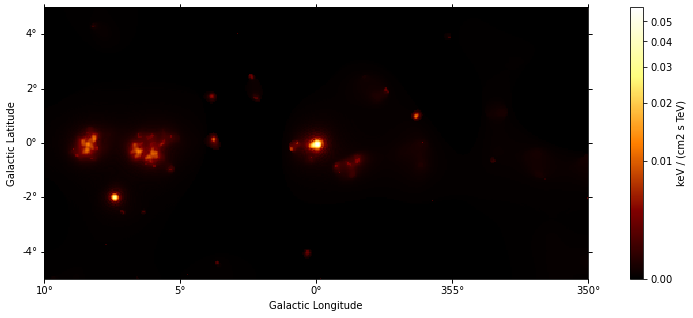

In [4]:
plt.figure(figsize=(15, 5))
images["flux"].plot(add_cbar=True, stretch="asinh");

## TS map estimation

The Test Statistic, TS = 2 ∆ log L ([Mattox et al. 1996](https://ui.adsabs.harvard.edu/abs/1996ApJ...461..396M/abstract)), compares the likelihood function L optimized with and without a given source.
The TS map is computed by fitting by a single amplitude parameter on each pixel as described in Appendix A of [Stewart (2009)](https://ui.adsabs.harvard.edu/abs/2009A%26A...495..989S/abstract). The fit is simplified by finding roots of the derivative of the fit statistics (default settings use [Brent's method](https://en.wikipedia.org/wiki/Brent%27s_method)).

We first need to define the model that will be used to test for the existence of a source. Here, we use a point source.

In [5]:
spatial_model = PointSpatialModel()
spectral_model = PowerLawSpectralModel(index=2)
model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)

In [6]:
%%time
estimator = TSMapEstimator(
    model,
    kernel_width="1 deg",
    selection_optional=[],
    e_edges=[10, 500] * u.GeV,
)
maps = estimator.run(dataset)

CPU times: user 16.6 s, sys: 337 ms, total: 16.9 s
Wall time: 16.9 s


### Plot resulting images

(<Figure size 1080x360 with 2 Axes>,
 <WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>,
 <matplotlib.colorbar.Colorbar at 0x7fb88e839390>)

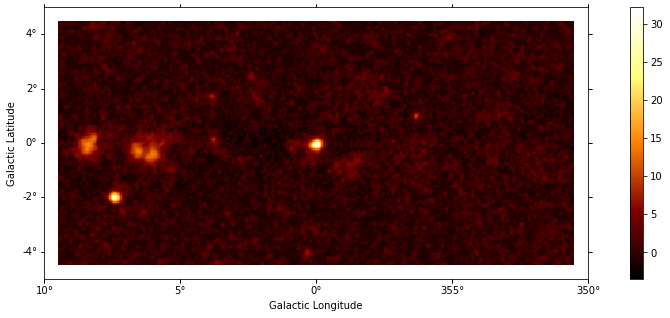

In [7]:
plt.figure(figsize=(15, 5))
maps["sqrt_ts"].plot(add_cbar=True);

/usr/share/miniconda/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


(<Figure size 1080x360 with 2 Axes>,
 <WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>,
 <matplotlib.colorbar.Colorbar at 0x7fb88e7a9940>)

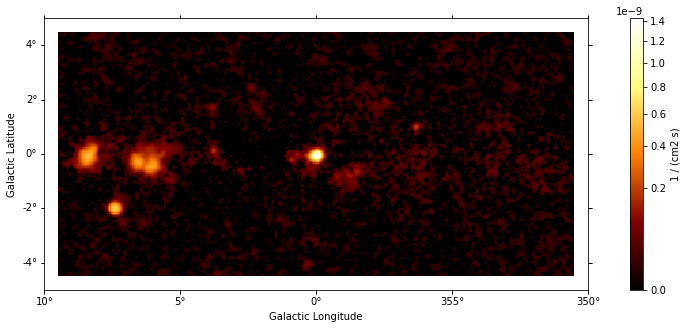

In [8]:
plt.figure(figsize=(15, 5))
maps["flux"].plot(add_cbar=True, stretch="sqrt", vmin=0);

(<Figure size 1080x360 with 2 Axes>,
 <WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>,
 <matplotlib.colorbar.Colorbar at 0x7fb88e6f31d0>)

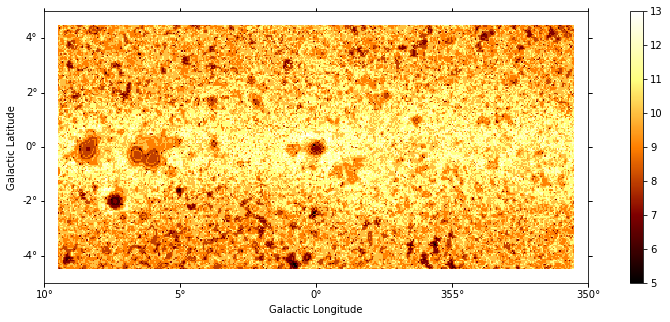

In [9]:
plt.figure(figsize=(15, 5))
maps["niter"].plot(add_cbar=True);

## Source candidates

Let's run a peak finder on the `sqrt_ts` image to get a list of point-sources candidates (positions and peak `sqrt_ts` values).
The `find_peaks` function performs a local maximun search in a sliding window, the argument `min_distance` is the minimum pixel distance between peaks (smallest possible value and default is 1 pixel).

In [10]:
sqrt_ts_image = maps["sqrt_ts"].get_image_by_idx((0,))
sources = find_peaks(sqrt_ts_image, threshold=5, min_distance="0.25 deg")
nsou = len(sources)
sources

value,x,y,ra,dec
,,,deg,deg
float64,int64,int64,float64,float64
32.242,200,99,266.41449,-28.97054
27.846,52,60,272.43197,-23.54282
15.213,32,98,271.16056,-21.74479
14.176,69,93,270.40919,-23.47797
13.923,80,92,270.15899,-23.98049
9.7645,273,119,263.18257,-31.52587
8.7988,124,102,268.46711,-25.63326
7.3528,123,134,266.97596,-24.77174


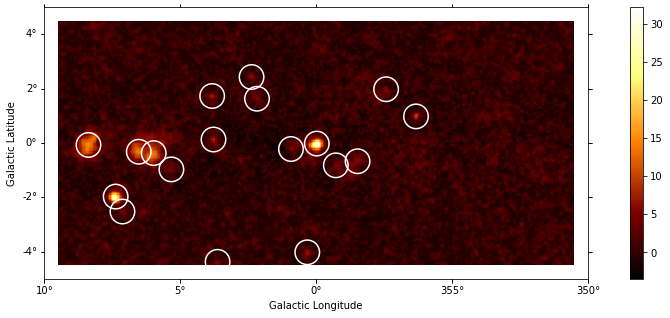

In [11]:
# Plot sources on top of significance sky image
plt.figure(figsize=(15, 5))

_, ax, _ = maps["sqrt_ts"].plot(add_cbar=True)

ax.scatter(
    sources["ra"],
    sources["dec"],
    transform=plt.gca().get_transform("icrs"),
    color="none",
    edgecolor="w",
    marker="o",
    s=600,
    lw=1.5,
);

Note that we used the instrument point-spread-function (PSF) as kernel, so the hypothesis we test is the presence of a point source. In order to test for extended sources we would have to use as kernel an extended template convolved by the PSF. Alternatively, we can compute the significance of an extended excess using the Li & Ma formalism, which is faster as no fitting is involve.

## What next?

In this notebook, we have seen how to work with images and compute TS and significance images from counts data, if a background estimate is already available.

Here's some suggestions what to do next:

- Look how background estimation is performed for IACTs with and without the high-level interface in [analysis_1](analysis_1.ipynb) and [analysis_2](analysis_2.ipynb) notebooks, respectively
- Learn about 2D model fitting in the [modeling 2D](modeling_2D.ipynb) notebook
- find more about Fermi-LAT data analysis in the [fermi_lat](fermi_lat.ipynb) notebook
- Use source candidates to build a model and perform a 3D fitting (see [analysis_3d](analysis_3d.ipynb), [analysis_mwl](analysis_mwl.ipynb) notebooks for some hints)